In [3]:
import numpy as np
import pandas as pd
from statsmodels.stats.proportion import proportions_ztest
import seaborn as sns
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison
from statsmodels.stats.multicomp import proportions_ztest
from statsmodels.stats.multicomp import proportions_chisquare

ImportError: cannot import name 'proportions_ztest' from 'statsmodels.stats.multicomp' (/opt/homebrew/lib/python3.10/site-packages/statsmodels/stats/multicomp.py)

# Scenario 1: Private Investigator. 
#### 28 out of 94 claimants are not nearly as "disabled" as their diagnosis suggests & hypothetical level of fraud is 16%
### We are comparing a sample ratio to a whole, so we will conduct a t-test

In [4]:
count = 28 
nobs = 94 
value = .16 
stat, pval = proportions_ztest(count, nobs, value) 
print(stat, pval)

2.9229268377264077 0.0034675798365736213


In [5]:
t, p = proportions_ztest(28, 94, 0.16)
t, p

(2.9229268377264077, 0.0034675798365736213)

### This is a significant difference between the claimants from this insurance company 
### claiming they are "disabled" than the industry norm of 16%

# Scenario 2: Anticeptics
## Running an Independent Chi-Square

In [6]:
antiseptics = pd.read_csv('/Users/britfathi/Downloads/antiseptics.csv')
antiseptics.head()

,Clinic,Antiseptic Type,Number of applications
0,1,A,22
1,1,B,71
2,1,C,8
3,1,D,49
4,2,A,38


In [7]:
antiseptic1 = pd.read_csv('/Users/britfathi/Downloads/antiseptics.csv')
antiseptic1.rename(columns={"Antiseptic Type ": "AT", 'Number of applications': "Count"}, inplace = True)
antiseptic1.head()

,Clinic,AT,Count
0,1,A,22
1,1,B,71
2,1,C,8
3,1,D,49
4,2,A,38


In [8]:
antiseptics_pivot = pd.pivot_table(antiseptic1,index='AT',columns='Clinic',values = 'Count')
antiseptics_pivot

Clinic,1,2,3
AT,,,
A,22,38,84
B,71,112,298
C,8,14,37
D,49,69,182


In [9]:
stats.chi2_contingency(antiseptics_pivot)

Chi2ContingencyResult(statistic=1.225920250023835, pvalue=0.9755850789571424, dof=6, expected_freq=array([[ 21.95121951,  34.09756098,  87.95121951],
       [ 73.32317073, 113.8953252 , 293.78150407],
       [  8.99390244,  13.97052846,  36.03556911],
       [ 45.73170732,  71.03658537, 183.23170732]]))

#### pvalue means we accept the null hypothesis. There is no difference of the location and the use of the antiseptic. 

# Scenario 3: Savings Practices
## We will be doing an ANOVA 
### because we have continuious dependent variable (the average account balance) and
### they want to know if it is dependant on the demographics for marketing purposes. 

In [10]:
## Import data

savings = pd.read_csv('/Users/britfathi/Downloads/savings.csv')
savings.head()

,Group A,Group B,Group C,Group D
0,21383.06,17077.54,13636.38,14582.73
1,19729.92,17258.06,5156.36,12880.28
2,24071.53,20652.91,4446.92,16412.72
3,19056.28,20845.06,4892.59,14020.00
4,19147.18,22296.64,14099.38,16467.70


In [11]:
savings_expanded = pd.melt(savings, var_name="Group", value_name='$')
savings_expanded.head()

,Group,$
0,Group A,21383.06
1,Group A,19729.92
2,Group A,24071.53
3,Group A,19056.28
4,Group A,19147.18


In [12]:
savings_expanded = savings_expanded.replace(savings.columns, [0,1,2,3])
savings_expanded.head()

,Group,$
0,0,21383.06
1,0,19729.92
2,0,24071.53
3,0,19056.28
4,0,19147.18


## Test for normality

/var/folders/t5/4lqy4g_n1z14zq1k52ld2cx00000gn/T/ipykernel_63953/1891789050.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(savings[~np.isnan(savings.values)])


<Axes: ylabel='Density'>

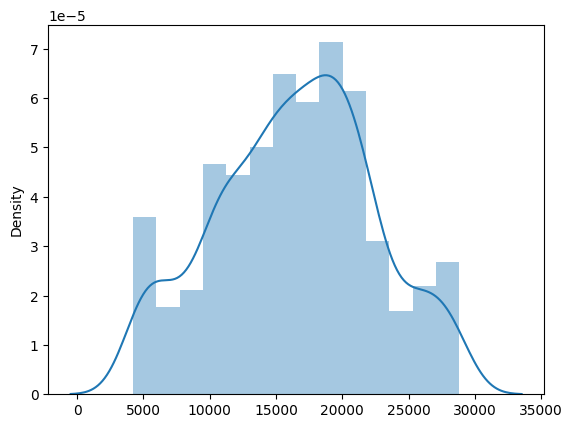

In [13]:
sns.distplot(savings[~np.isnan(savings.values)])
## Pretty close to normal

## Test for homogeneity of variance. 

In [14]:
import scipy
### tried loading it above and it gave me weird warnings. 

In [15]:
scipy.stats.bartlett(savings_expanded['$'], savings_expanded['Group'])

BartlettResult(statistic=3639.1753663764925, pvalue=0.0)

### Does not meet the assumption of homogeneity of variance because pvalue is <.05 

In [16]:
scipy.stats.fligner(savings_expanded['$'], savings_expanded['Group'])
#### Not sure why I get a nan on Fligner's

FlignerResult(statistic=nan, pvalue=nan)

In [18]:
save = [savings[col].dropna() for col in savings]

In [19]:
stats.f_oneway(*save)

F_onewayResult(statistic=203.25514198903812, pvalue=1.9933595578005075e-61)

In [21]:
savings_expanded.dropna(inplace=True)

In [22]:
stats.f_oneway(savings_expanded['$'][savings_expanded['Group']==0],
              savings_expanded['$'][savings_expanded['Group']==1],
              savings_expanded['$'][savings_expanded['Group']==2],
              savings_expanded['$'][savings_expanded['Group']==3])

F_onewayResult(statistic=203.25514198903812, pvalue=1.9933595578005075e-61)

#### This p-value means there is a difference between demographic groups, but this is also said cautiously because of the failed assumptions. 


## Post Hoc

In [25]:
postHoc = MultiComparison(savings_expanded['$'],savings_expanded['Group'])
postHocResults = postHoc.tukeyhsd()
print(postHocResults)

     Multiple Comparison of Means - Tukey HSD, FWER=0.05      
group1 group2   meandiff  p-adj    lower       upper    reject
--------------------------------------------------------------
     0      1  -4835.5416   0.0    -6431.09  -3239.9931   True
     0      2 -14174.3925   0.0 -15708.3646 -12640.4204   True
     0      3  -8384.0728   0.0  -9898.8374  -6869.3083   True
     1      2  -9338.8509   0.0 -10906.3265  -7771.3754   True
     1      3  -3548.5313   0.0  -5097.2149  -1999.8477   True
     2      3   5790.3197   0.0   4305.1542   7275.4851   True
--------------------------------------------------------------


In [27]:
savings1 = savings_expanded[['$', 'Group']]

In [28]:
savings1.groupby("Group").mean()

,$
Group,
0,23401.849216
1,18566.307660
2,9227.456727
3,15017.776379


### Cautiously, we can say their savings does differ by demographic groups, with group 2 having the lowest average savings, and group 1 having the highest average savings. 

# Scenario 4: School Bond

## This is a two-proportion z-test Comparing proportions of those with children and without children those who are or are not in favor of the bond. 

In [31]:
from statsmodels.stats.proportion import proportions_ztest

In [38]:
count = np.array([374, 171]) 
nobs = np.array([374+129, 171+74])
stat, pval = proportions_ztest(count, nobs) 
print(stat, pval)

1.3156546893290748 0.18828996870412507


In [37]:
stat, pval = proportions_ztest([374,171],[374+129, 171+74])
print(stat,pval)

1.3156546893290748 0.18828996870412507


### There is no statistical difference between those with children and those without children who favored the school bond. 